* Import the necessary libraries for computations and plotting

In [436]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd  
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

In [437]:
def grid(bvp): 
        
    x = np.linspace(0, 1, bvp.M)
    y = np.linspace(0, 1, bvp.N)
    
    # these ones are valid only for this case
    # in general the radius of the smallest inscribed
    # circle should be taken
    h=x[1]-x[0] # x typical space-step
    k=y[1]-y[0] # y typical space-step
    
    # full coorindate array of INTERNAL points
    shape = [len(x[1:-1]), len(y[1:-1])]
    x, y = np.meshgrid(x[1:-1], y[1:-1])

    # reshaping so that I have columnwise vectors
    # with all the x and y coordinates. In practice, THIS passage already
    # re-order the array in a vector that follows the numbering explained
    # in the figure above
    x, y = x.flatten(), y.flatten()
    
    # array with coordinates
    coord = np.zeros((x.size,2))
    coord[:,0]=x
    coord[:,1]=y
    
    return h, k, coord, shape

* Construct a class for the boundary value problem (BVP).

In [438]:
class BVP(object): 
    def __init__(self, f, g=0, a = 0 , M=10, N=10):
        # right hand side (function)
        self.f = f
        # boundary conditions (function)
        self.a = a
        self.g = g
        # Numbr of subdivision along x-axis (total number of points, including boundaries)
        self.M = M
        # Numbr of subdivision along y-axis (total number of points, including boundaries)
        self.N = N

* Implement the solver. 

In [439]:
def solve_bvp(bvp, c):
    # Retrieving the mesh sizes in the two dimensions,
    # the coordinates of the points (ordered) and the
    # shape of the array of INTERNAL points
    h, k, coord, shape = grid(bvp)
    
    # Initialization of the algebraic system
    A=np.zeros((coord[:,1].size,coord[:,1].size));
    b=np.zeros(len(coord[:,1]));
    
    # Addition of the forcing term
    b += bvp.f(bvp.a, coord[:,0],coord[:,1])
    # number of internal points along x in one row
    # needed to locate the points around a chosen point
    M_int = shape[0]
    
    # tolerance in checking a node is on the boundary
    tol = 1e-10
    
    # Filling the matrix row by row (not efficient, done for educational purposes)
    for i, (x,y) in enumerate(zip(coord[:,0], coord[:,1])):

        # N.B.: the command enumerate(zip(coord[:,0], coord[:,1])) just bind together
        # the two columns of coord (the x and y coordinates of my internal points) so that
        # they can be used in the cycle for. In this way, when the iterator "i" is a certain number
        # the variables "x" and "y" contain the respective coordinates of the correspondin points
        # in the i-th row of the array "coord"
        
        A[i,i] = 2*bvp.a/h**2 + 2/(c*k**2)
        
        # check if the stencil touches the left boundary
        if (math.isclose(x-h,0, abs_tol = tol)):
            
            A[i,i+1] = -bvp.a/h**2
            b[i] += bvp.a*bvp.g(x-h,y)/h**2 + bvp.g(x-h,y-k)/(c*k**2) 
            
            # check it the stencil touches also the upper boundary
            if (math.isclose(y+k,1., abs_tol = tol)):                
                b[i] += bvp.g(x+h,y+k)/(c*k**2)
            else:
                A[i+1,i+M_int] = -1/(c*k**2)
        # check if the stencil touches the right boundary
        elif (math.isclose(x+h,1., abs_tol = tol)):
            
            A[i,i-1] = -bvp.a/h**2
            b[i] += bvp.a*bvp.g(x+h,y)/h**2 + bvp.g(x+h,y+k)/(c*k**2)
                
            # check if the stencil touches also the lower boundary
            if (math.isclose(y-k,0., abs_tol = tol)):
                b[i] += bvp.g(x-h,y-k)/(c*k**2)
            else:
                A[i-1,i-M_int] = -1/(c*k**2)
                
        else:
            # the stencil touches neither right or left boundary
            A[i,i+1] = -bvp.a/h**2
            A[i,i-1] = -bvp.a/h**2
            
            # check if the stencil touches the upper boundary
            if (math.isclose(y+k,1., abs_tol = tol)):
                b[i] += bvp.g(x+h,y+k)/(c*k**2)
            else:
                A[i+1,i+M_int] = -1/(c*k**2)
            #check if the stencil touches the lower boundary
            if (math.isclose(y-k,0., abs_tol = tol)):
                b[i] += bvp.g(x-h,y-k)/(c*k**2)
            else:
                A[i-1,i-M_int] = -1/(c*k**2)
    
    # Plot the structure of the assembled array
    plt.spy(A)
    # Solve the linear system
    U = np.linalg.solve(A, b)
    # Just flip the vector
    #U = np.reshape(U,-1)

    return U, A, coord

## Run a numerical test



In [440]:
M = N = 100
a = 1
#RHS
def f_1(a, x, y):
    return (2*a*y**2 - 2*a*y + 8*x*y + 2*x**2 + 2*y**2 - 6*x -6*y +2 )
def u_sol_1(x,y):
    return x*(1-x)*y*(1-y)

def u_sol_2(x,y):
    return x * y

def f_2(a, x, y):
    return 2

def f_3(a,x, y):
    return 2*np.pi**2 * np.cos(np.pi*x) * np.cos(np.pi * y) - 2 * np.pi**2 * np.sin(np.pi * y) *np.sin(np.pi *x) - a*np.pi**2*np.sin(np.pi* x) * np.sin(np.pi * y)

def u_sol_3(x,y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)

def f_1(a, x, y):
    return (2*a*y**2 - 2*a*y + 8*x*y + 2*x**2 + 2*y**2 - 6*x -6*y +2 )
def u_sol_1(x,y):
    return x*(1-x)*y*(1-y)

#Boundary conditions
def g(x,y):
    return 0 


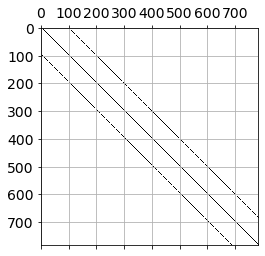

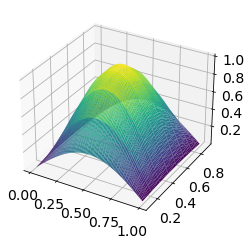

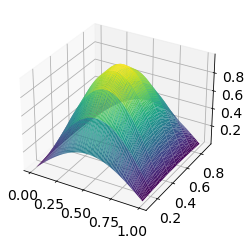

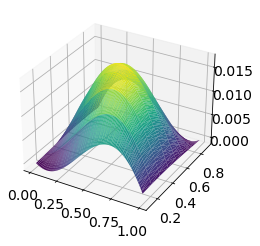

0.017330487421563734

In [441]:
ex1 = BVP(f_3,u_sol_3,M,N)
# Solution of the problem

U, A, coord = solve_bvp(ex1, 4)
# Plot of the solution
plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], -U,
                cmap='viridis', edgecolor='none');
plt.show()

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], u_sol_3(coord[:,0], coord[:,1]),cmap='viridis', edgecolor='none')
plt.show()

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], -U - u_sol_3(coord[:,0], coord[:,1]),cmap='viridis', edgecolor='none')
plt.show()

np.max(np.abs(-U - u_sol_3(coord[:,0], coord[:,1])))

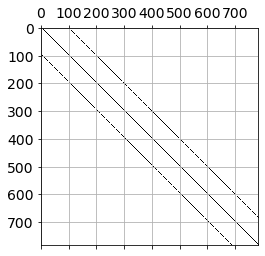

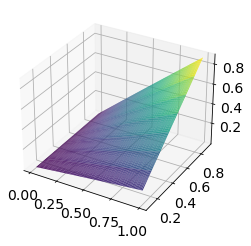

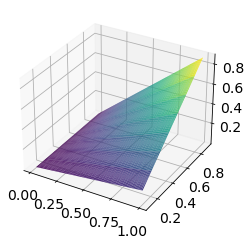

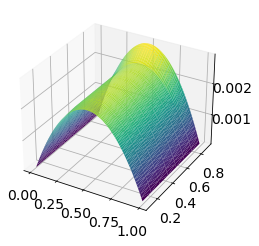

0.0028766772374991256

In [442]:
ex1 = BVP(f_2,u_sol_2,M,N)
# Solution of the problem
U, A, coord = solve_bvp(ex1,4)
# Plot of the solution
plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], U,
                cmap='viridis', edgecolor='none');
plt.show()

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], u_sol_2(coord[:,0], coord[:,1]),cmap='viridis', edgecolor='none')
plt.show()

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], U - u_sol_2(coord[:,0], coord[:,1]),cmap='viridis', edgecolor='none')
plt.show()

np.max(np.abs(U - u_sol_2(coord[:,0], coord[:,1])))

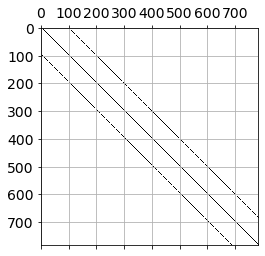

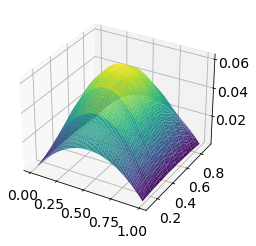

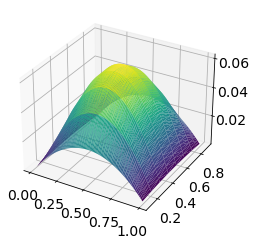

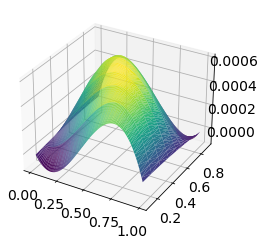

0.000611734529511361

In [443]:
ex1 = BVP(f_1,u_sol_1,M,N)
# Solution of the problem
U, A, coord = solve_bvp(ex1, 1)
# Plot of the solution
plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], -U,
                cmap='viridis', edgecolor='none');
plt.show()

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], u_sol_1(coord[:,0], coord[:,1]),cmap='viridis', edgecolor='none')
plt.show()

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], -U - u_sol_1(coord[:,0], coord[:,1]),cmap='viridis', edgecolor='none')
plt.show()
np.max(np.abs(-U - u_sol_1(coord[:,0], coord[:,1])))

Notice that the solution on the boundary is not plotted here. 